# High-dimensional, Multi-Objective Optimization with Existing Data

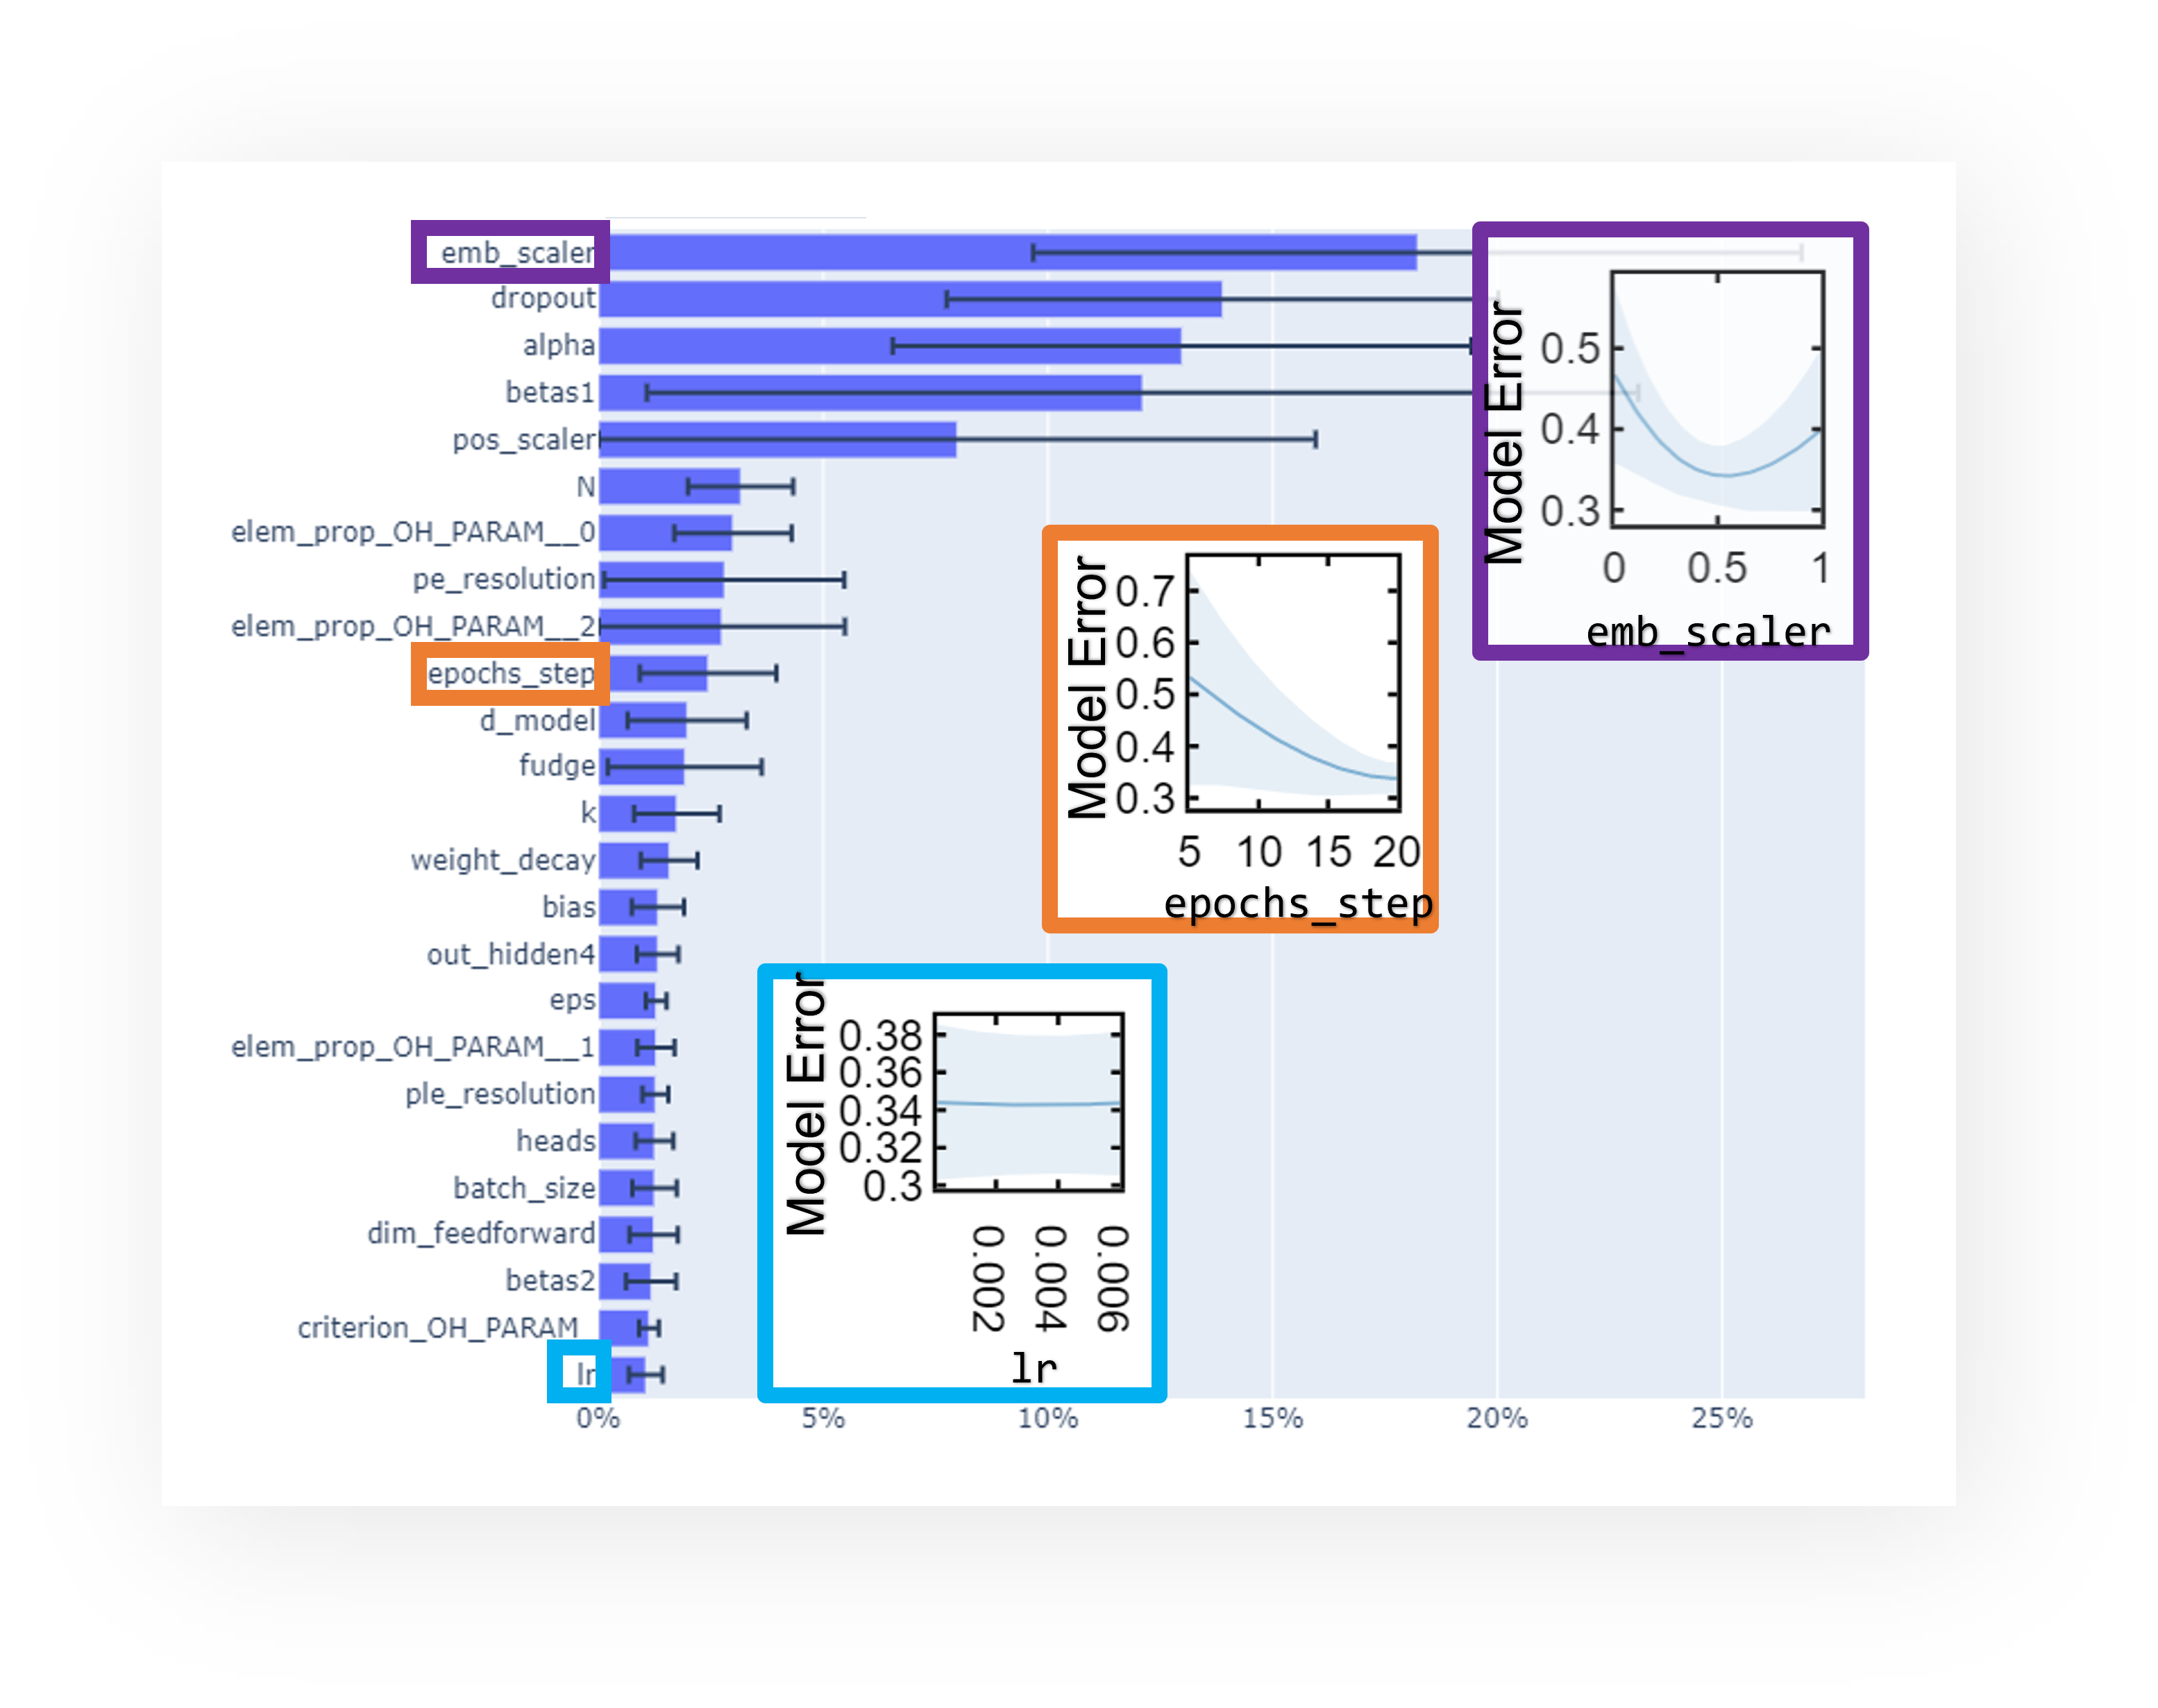

In [3]:
# For notebook gallery thumbnail
from IPython.display import Image
Image(filename="../saasbo-feature-importances.png")

See https://github.com/facebook/Ax/issues/743

In [1]:
%pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


In [2]:
# %% imports
import numpy as np
import pandas as pd

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

unique_components = ["filler_A", "filler_B", "resin_A", "resin_B", "resin_C"]

X_train = np.array([
       [0.4, 0.4, 0. , 0. , 0.2],
       [0.5, 0. , 0. , 0.5, 0. ],
       [0.5, 0.3, 0. , 0.2, 0. ],
       [0.5, 0. , 0. , 0.5, 0. ],
       [0. , 0.6, 0.4, 0. , 0. ],
       [0.6, 0. , 0.4, 0. , 0. ],
       [0. , 0.6, 0.2, 0.2, 0. ]])

X_train = pd.DataFrame(X_train, columns=unique_components)
X_train

,filler_A,filler_B,resin_A,resin_B,resin_C
0,0.4,0.4,0.0,0.0,0.2
1,0.5,0.0,0.0,0.5,0.0
2,0.5,0.3,0.0,0.2,0.0
3,0.5,0.0,0.0,0.5,0.0
4,0.0,0.6,0.4,0.0,0.0
5,0.6,0.0,0.4,0.0,0.0
6,0.0,0.6,0.2,0.2,0.0


In [3]:
np.random.seed(10)
n_train = X_train.shape[0]
num_objectives = 2
y_train = 100 * np.random.rand(n_train, num_objectives)
y_train

array([[77.13206433,  2.07519494],
       [63.36482349, 74.88038825],
       [49.85070123, 22.47966455],
       [19.80628648, 76.05307122],
       [16.91108366,  8.83398142],
       [68.53598184, 95.33933462],
       [ 0.39482663, 51.21922634]])

In [4]:
# Ax-specific
parameters = [
    {"name": component, "type": "range", "bounds": [0.0, 1.0]}
    for component in unique_components[:-1]
]
parameters

[{'name': 'filler_A', 'type': 'range', 'bounds': [0.0, 1.0]},
 {'name': 'filler_B', 'type': 'range', 'bounds': [0.0, 1.0]},
 {'name': 'resin_A', 'type': 'range', 'bounds': [0.0, 1.0]},
 {'name': 'resin_B', 'type': 'range', 'bounds': [0.0, 1.0]}]

In [5]:
separator = " + "
composition_constraint = separator.join(unique_components[:-1]) + " <= 1.0"
composition_constraint

'filler_A + filler_B + resin_A + resin_B <= 1.0'

In [9]:
# skip the pseudo-random suggested points by specifying a custom generation strategy
gs = GenerationStrategy(
    steps=[
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.FULLYBAYESIANMOO,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        ),
    ]
)

objectives = {
    "yield_strength": ObjectiveProperties(minimize=False),
    "elongation": ObjectiveProperties(minimize=False),
}

# setup the experiment
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="dummy",
    parameters=parameters,
    parameter_constraints=[
        composition_constraint,
    ],
    objectives=objectives,
)

[INFO 02-18 04:13:20] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-18 04:13:20] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 02-18 04:13:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter filler_A. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-18 04:13:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter filler_B. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-18 04:13:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter resin_A. If that i

In [12]:
# attach the training data
for i in range(n_train):
    ax_client.attach_trial(X_train.iloc[i, :-1].to_dict())
    ax_client.complete_trial(trial_index=i, raw_data={"yield_strength": y_train[i, 0], "elongation": y_train[i, 1]})

[INFO 02-18 04:13:50] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.4, 'filler_B': 0.4, 'resin_A': 0.0, 'resin_B': 0.0} as trial 1.
[INFO 02-18 04:13:51] ax.service.ax_client: Completed trial 0 with data: {'yield_strength': (77.132064, None), 'elongation': (2.075195, None)}.
[INFO 02-18 04:13:51] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.5, 'filler_B': 0.0, 'resin_A': 0.0, 'resin_B': 0.5} as trial 2.
[INFO 02-18 04:13:51] ax.service.ax_client: Completed trial 1 with data: {'yield_strength': (63.364823, None), 'elongation': (74.880388, None)}.
[INFO 02-18 04:13:51] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.5, 'filler_B': 0.3, 'resin_A': 0.0, 'resin_B': 0.2} as trial 3.
[INFO 02-18 04:13:51] ax.service.ax_client: Completed trial 2 with data: {'yield_strength': (49.850701, None), 'elongation': (22.479665, None)}.
[INFO 02-18 04:13:51] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.5, 'fi

In [13]:
# produce a *single* next suggested experiment, be sure to only run this once
next_experiment, trial_index = ax_client.get_next_trial()
print("next suggested experiment: ", next_experiment)

Sample: 100%|██████████| 768/768 [00:50, 15.26it/s, step size=4.75e-01, acc. prob=0.907]
[INFO 02-18 04:15:42] ax.service.ax_client: Generated new trial 8 with parameters {'filler_A': 0.0, 'filler_B': 1.0, 'resin_A': 0.0, 'resin_B': 0.0}.


next suggested experiment:  {'filler_A': 0.0, 'filler_B': 1.0, 'resin_A': 5.645796473207701e-16, 'resin_B': 0.0}


In [16]:
# note that the model fit is poor because of the toy data and randomly generated objective values
# (i.e. this is what we would expect: a bad fit, because the "true" values are nonsense)
pareto_optimal_parameters = ax_client.get_pareto_optimal_parameters()
print(pareto_optimal_parameters)

Sample: 100%|██████████| 768/768 [00:48, 15.88it/s, step size=5.32e-01, acc. prob=0.907]
[INFO 02-18 04:21:01] ax.service.utils.best_point: Using inferred objective thresholds: [ObjectiveThreshold(elongation >= 47.00879661731586), ObjectiveThreshold(yield_strength >= 60.39932872713746)], as objective thresholds were not specified as part of the optimization configuration on the experiment.


{5: ({'filler_A': 0.0, 'filler_B': 0.6, 'resin_A': 0.4, 'resin_B': 0.0}, ({'elongation': 77.6029745114039, 'yield_strength': 68.73797698029448}, {'elongation': {'elongation': 443.2025659448865, 'yield_strength': 0.0}, 'yield_strength': {'elongation': 0.0, 'yield_strength': 211.24414246096174}}))}


/usr/local/lib/python3.8/dist-packages/ax/modelbridge/modelbridge_utils.py:831: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(
